<a href="https://colab.research.google.com/github/caiomocny/MachineLearning-Recurrent_Neural_Network_RNN/blob/main/Caio_Mocny_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# RNN - Recurrent Neural Network

In [ ]:
# Libraries
import folium
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import os
import pandas as pd
import seaborn as sns
import zipfile

from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
from google.colab import files # COLAB
from tensorflow.keras import backend
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [ ]:
# COLAB - Load Dataset. Data of crimes in Vancouver (Canada) from 2003 to 2017. EDA (https://www.kaggle.com/wosaku/eda-of-crime-in-vancouver-2003-2017)
!wget https://github.com/Valdecy/Datasets/raw/master/Data%20Science/AI-04-RNN-Crimes.zip

--2021-12-14 20:56:01--  https://github.com/Valdecy/Datasets/raw/master/Data%20Science/AI-04-RNN-Crimes.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Valdecy/Datasets/master/Data%20Science/AI-04-RNN-Crimes.zip [following]
--2021-12-14 20:56:01--  https://raw.githubusercontent.com/Valdecy/Datasets/master/Data%20Science/AI-04-RNN-Crimes.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11151806 (11M) [application/zip]
Saving to: ‘AI-04-RNN-Crimes.zip.4’

AI-04-RNN-Crimes.zi 100%[===================>]  10.63M  --.-KB/s    in 0.1s    

2021-12-14 20:56:01 (97.6 MB/s) - ‘AI-04-RNN-Crimes.zip.

In [ ]:
# Unzip Dataset
single_file = 'AI-04-RNN-Crimes.zip' 
with zipfile.ZipFile(single_file, 'r') as zf:
    zf.extract('AI-04-RNN-Crimes.txt')

In [ ]:
# Working Directory
print(os.listdir())

['.config', 'AI-04-RNN-Crimes.zip.2', 'lstm.hdf5', 'AI-04-RNN-Crimes.zip.4', 'AI-04-RNN-Crimes.zip.3', 'AI-04-RNN-Crimes.zip.1', 'AI-04-RNN-Crimes.zip', 'AI-04-RNN-Crimes.txt', 'sample_data']


In [ ]:
# Load and Check Dataset
dataset = pd.read_csv('AI-04-RNN-Crimes.txt', sep = ',')
dataset.head(n = 10)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,Other Theft,2003,5,12,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
1,Other Theft,2003,5,7,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
2,Other Theft,2003,4,23,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
3,Other Theft,2003,4,20,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
4,Other Theft,2003,4,12,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
5,Other Theft,2003,3,26,20.0,45.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
6,Break and Enter Residential/Other,2003,3,10,12.0,0.0,63XX WILTSHIRE ST,Kerrisdale,489325.58,5452817.95,49.228051,-123.146610
7,Mischief,2003,6,28,4.0,13.0,40XX W 19TH AVE,Dunbar-Southlands,485903.09,5455883.77,49.255559,-123.193725
8,Other Theft,2003,2,16,9.0,2.0,9XX TERMINAL AVE,Strathcona,493906.50,5457452.47,49.269802,-123.083763
9,Break and Enter Residential/Other,2003,7,9,18.0,15.0,18XX E 3RD AVE,Grandview-Woodland,495078.19,5457221.38,49.267734,-123.067654


In [ ]:
# Drop Unecessary Columns
dataset = dataset.drop(columns = ['MINUTE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'X', 'Y'])
dataset.head(n = 10)

,TYPE,YEAR,MONTH,DAY,HOUR,Latitude,Longitude
0,Other Theft,2003,5,12,16.0,49.269802,-123.083763
1,Other Theft,2003,5,7,15.0,49.269802,-123.083763
2,Other Theft,2003,4,23,16.0,49.269802,-123.083763
3,Other Theft,2003,4,20,11.0,49.269802,-123.083763
4,Other Theft,2003,4,12,17.0,49.269802,-123.083763
5,Other Theft,2003,3,26,20.0,49.269802,-123.083763
6,Break and Enter Residential/Other,2003,3,10,12.0,49.228051,-123.146610
7,Mischief,2003,6,28,4.0,49.255559,-123.193725
8,Other Theft,2003,2,16,9.0,49.269802,-123.083763
9,Break and Enter Residential/Other,2003,7,9,18.0,49.267734,-123.067654


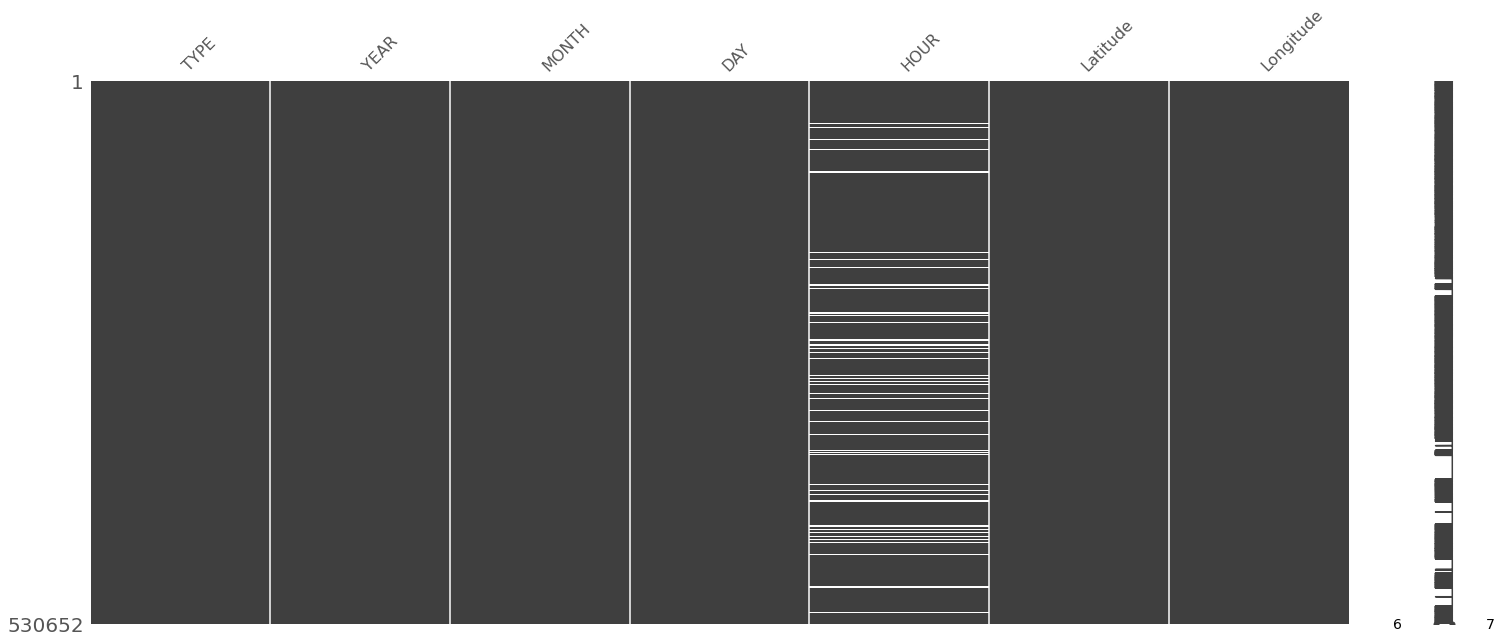

In [ ]:
# Check Missing Data
plt.style.use('ggplot')
msno.matrix(dataset)

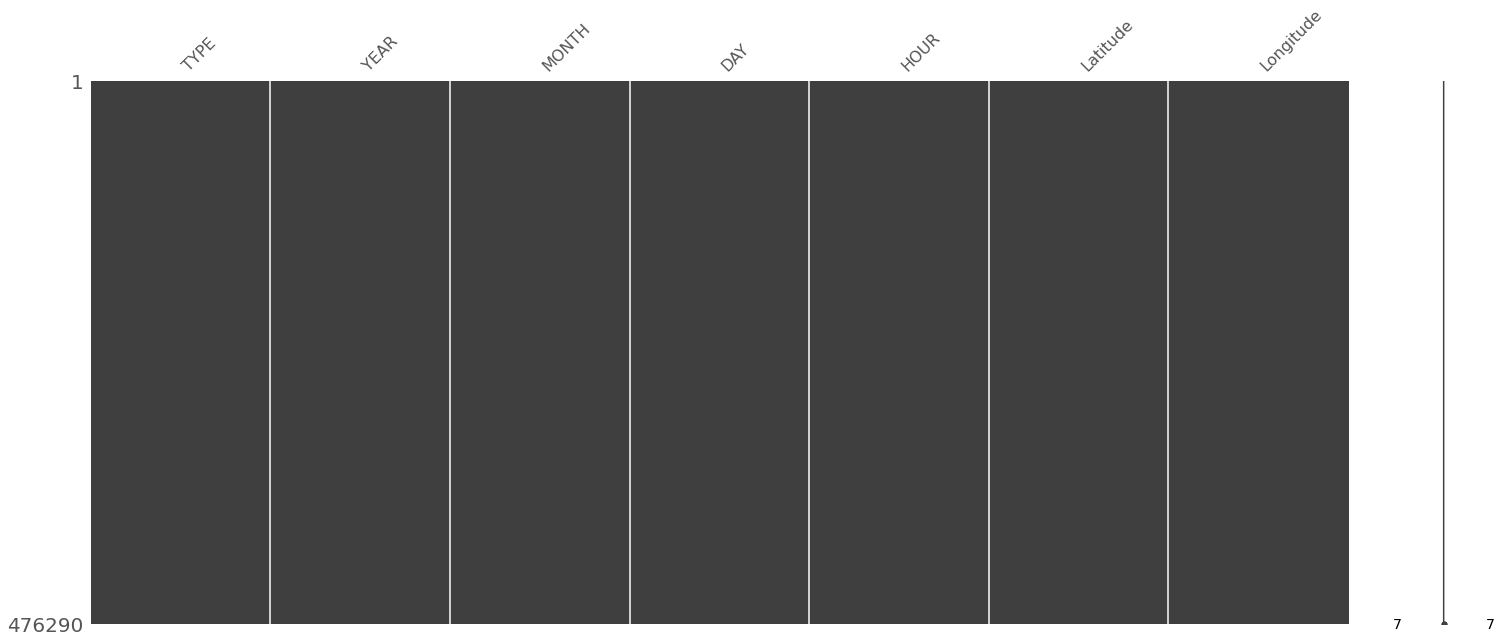

In [ ]:
# Drop Missing Data
dataset.dropna(subset = ['HOUR'], inplace = True)
dataset.reset_index()
plt.style.use('ggplot')
msno.matrix(dataset)

In [ ]:
# Insert Date Column
dataset['DATE'] = pd.to_datetime({'year':dataset['YEAR'], 'month':dataset['MONTH'], 'day':dataset['DAY']})
dataset.sort_values(by = ['YEAR', 'MONTH', 'DAY', 'HOUR'], ascending = True, inplace = True)
dataset.head(n = 2000)

,TYPE,YEAR,MONTH,DAY,HOUR,Latitude,Longitude,DATE
190,Theft from Vehicle,2003,1,1,0.0,49.278669,-123.125802,2003-01-01
955,Vehicle Collision or Pedestrian Struck (with I...,2003,1,1,0.0,49.282485,-123.128052,2003-01-01
2358,Break and Enter Residential/Other,2003,1,1,0.0,49.275692,-123.064898,2003-01-01
4972,Mischief,2003,1,1,0.0,49.211351,-123.141645,2003-01-01
9168,Theft from Vehicle,2003,1,1,0.0,49.248111,-123.127685,2003-01-01
...,...,...,...,...,...,...,...,...
46676,Theft from Vehicle,2003,1,15,18.0,49.285609,-123.134906,2003-01-15
47821,Theft from Vehicle,2003,1,15,18.0,49.281382,-123.076760,2003-01-15
6537,Break and Enter Residential/Other,2003,1,15,19.0,49.215648,-123.097754,2003-01-15
8660,Theft of Vehicle,2003,1,15,19.0,49.283897,-123.110119,2003-01-15


In [ ]:
# Insert 'DAY_OF_WEEK' Column (Monday = 0 to Sunday = 6)
dataset['DAY_OF_WEEK'] = dataset['DATE'].dt.dayofweek
dataset.head(n = 10)

,TYPE,YEAR,MONTH,DAY,HOUR,Latitude,Longitude,DATE,DAY_OF_WEEK
190,Theft from Vehicle,2003,1,1,0.0,49.278669,-123.125802,2003-01-01,2
955,Vehicle Collision or Pedestrian Struck (with I...,2003,1,1,0.0,49.282485,-123.128052,2003-01-01,2
2358,Break and Enter Residential/Other,2003,1,1,0.0,49.275692,-123.064898,2003-01-01,2
4972,Mischief,2003,1,1,0.0,49.211351,-123.141645,2003-01-01,2
9168,Theft from Vehicle,2003,1,1,0.0,49.248111,-123.127685,2003-01-01,2
15089,Break and Enter Residential/Other,2003,1,1,0.0,49.257848,-123.126558,2003-01-01,2
17138,Theft of Bicycle,2003,1,1,0.0,49.279617,-123.106816,2003-01-01,2
17599,Theft of Bicycle,2003,1,1,0.0,49.268399,-123.172906,2003-01-01,2
18185,Mischief,2003,1,1,0.0,49.275799,-123.069000,2003-01-01,2
18775,Theft of Bicycle,2003,1,1,0.0,49.278700,-123.127791,2003-01-01,2


In [ ]:
# Crime Types
dataset['TYPE'].value_counts().sort_index()

Break and Enter Commercial                                 33845
Break and Enter Residential/Other                          60862
Mischief                                                   70413
Other Theft                                                52167
Theft from Vehicle                                        172700
Theft of Bicycle                                           25730
Theft of Vehicle                                           38418
Vehicle Collision or Pedestrian Struck (with Fatality)       254
Vehicle Collision or Pedestrian Struck (with Injury)       21901
Name: TYPE, dtype: int64

In [ ]:
# Crime Vector
crimes_df       = dataset['TYPE'].copy(deep = True)
crimes_df.index = pd.DatetimeIndex(dataset['DATE'])
crimes_df.head()

DATE
2003-01-01                                   Theft from Vehicle
2003-01-01    Vehicle Collision or Pedestrian Struck (with I...
2003-01-01                    Break and Enter Residential/Other
2003-01-01                                             Mischief
2003-01-01                                   Theft from Vehicle
Name: TYPE, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


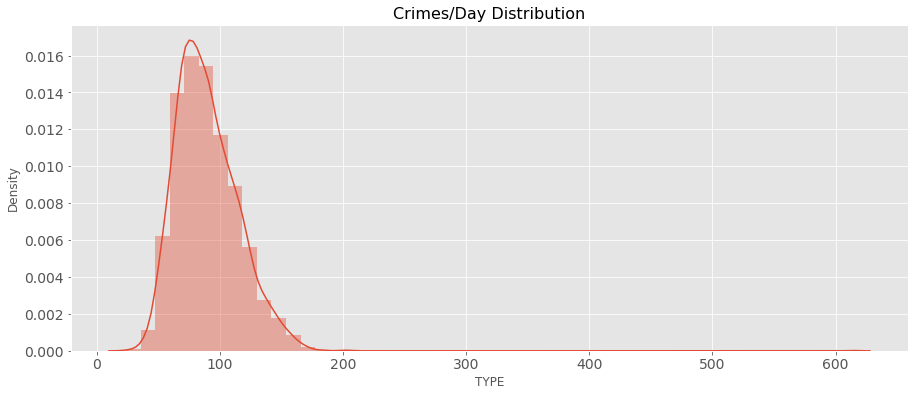

In [ ]:
# Crime Distribution
plt.figure(figsize = (15,6))
plt.title('Crimes/Day Distribution', fontsize = 16)
plt.tick_params(labelsize = 14)
sns.distplot(crimes_df.resample('D').size(), bins = 50)

In [ ]:
# Investigate Outlier
atypical_day = crimes_df.resample('D').size().idxmax()
print(atypical_day)
print('Number of Crimes in the Day: ', len(crimes_df[atypical_day]))

2011-06-15 00:00:00
Number of Crimes in the Day:  614


In [ ]:
# Investigate Outlier - Crime Types
crimes_df[atypical_day].value_counts()

Mischief                                                367
Break and Enter Commercial                              174
Theft from Vehicle                                       31
Theft of Bicycle                                         13
Other Theft                                              11
Break and Enter Residential/Other                        10
Theft of Vehicle                                          6
Vehicle Collision or Pedestrian Struck (with Injury)      2
Name: TYPE, dtype: int64

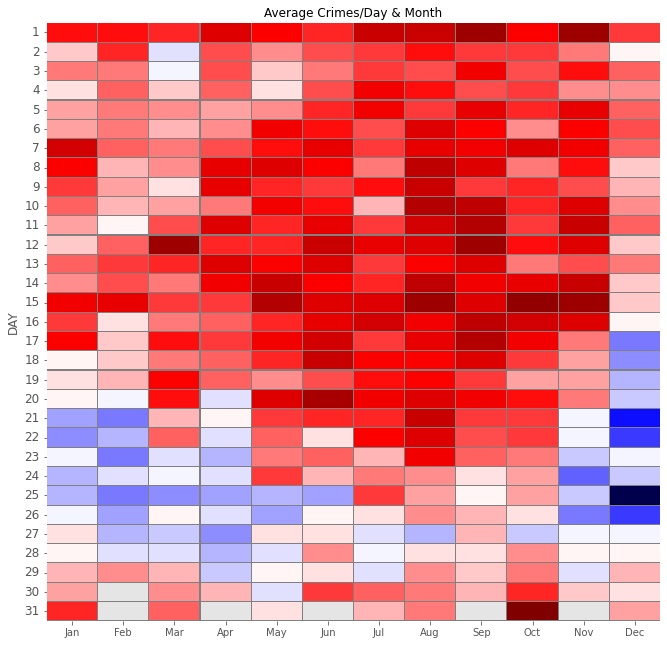

In [ ]:
# Plot Average Crimes/Day & Month
c1 = dataset[(dataset['DATE'] != atypical_day)].pivot_table(values = 'YEAR', index = 'DAY', columns = 'MONTH', aggfunc = len)
c2 = dataset[(dataset['DATE'] != atypical_day)].pivot_table(values = 'YEAR', index = 'DAY', columns = 'MONTH', aggfunc = lambda x: len(x.unique()))
c3 = c1/c2
c3.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Plot Heatmap
plt.figure(figsize = (11, 11))
plt.title('Average Crimes/Day & Month', fontsize = 12)
g = sns.heatmap(c3.round(), cmap = 'seismic', linecolor = 'grey', linewidths = 0.1, cbar = False, annot = False, fmt = '.0f')
g = g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)

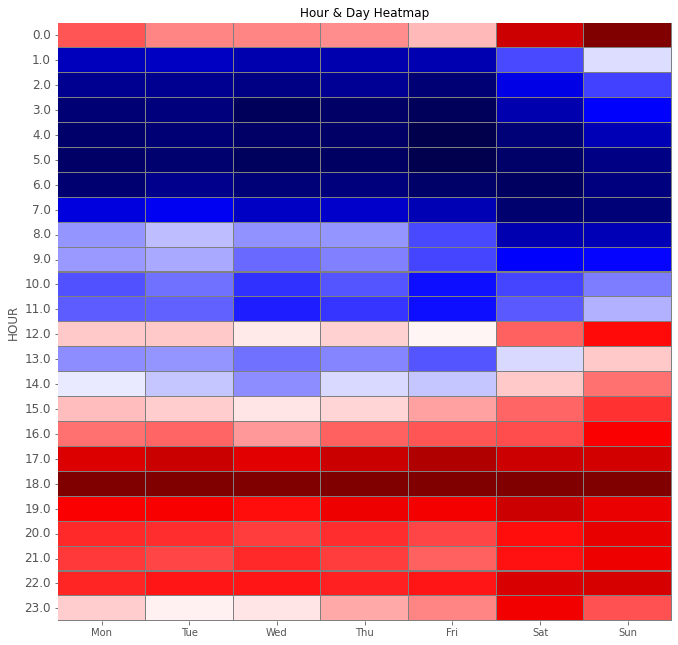

In [ ]:
# Plot Average Crimes/Hour & Day
c4 = dataset.pivot_table(values = 'TYPE', index = 'DAY_OF_WEEK', columns = 'HOUR', aggfunc = len)
c5 = pd.DataFrame(c4.loc[0] / c4.loc[0].max())
for i in range(0, 7):
    c5[i] = c4.loc[i] / c4.loc[i].max()
c5.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# Plot Heatmap
plt.figure(figsize = (11, 11))
plt.title('Hour & Day Heatmap', fontsize = 12)
g = sns.heatmap(c5,  cmap = 'seismic', linecolor = 'grey', linewidths = 0.1, cbar = False, annot = False)
g = g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)

In [ ]:
# Crime Types
data                    = dataset.copy(deep = True)
data.index              = pd.DatetimeIndex(data['DATE'])
crime_types             = data.groupby([data.DATE.dt.year, data.DATE.dt.month, data.DATE.dt.day]).TYPE.value_counts().unstack().fillna(0)
crime_types.columns     = ['Break and Enter Commercial' , 'Break and Enter Residential/Other', 'Mischief', 'Other Theft', 'Theft from Vehicle', 'Theft of Bicycle', 'Theft of Vehicle', 'Vehicle Collision or Pedestrian Struck (with Fatality)',  'Vehicle Collision or Pedestrian Struck (with Injury)']
crime_types.index.names = ['Year', 'Month', 'Day']
crime_types 

Break and Enter Commercial  ...  Vehicle Collision or Pedestrian Struck (with Injury)
Year Month Day                              ...                                                      
2003 1     1                          10.0  ...                                                8.0   
           2                           7.0  ...                                                4.0   
           3                          14.0  ...                                                4.0   
           4                           5.0  ...                                                5.0   
           5                          11.0  ...                                                1.0   
...                                    ...  ...                                                ...   
2017 7     9                           5.0  ...                                                4.0   
           10                          2.0  ...                                                3.0   
           11                          4.0  ...                                                2.0   
           12                          5.0  ...                                                4.0   
           13                          2.0  ...                                                3.0   

[5308 rows x 9 columns]

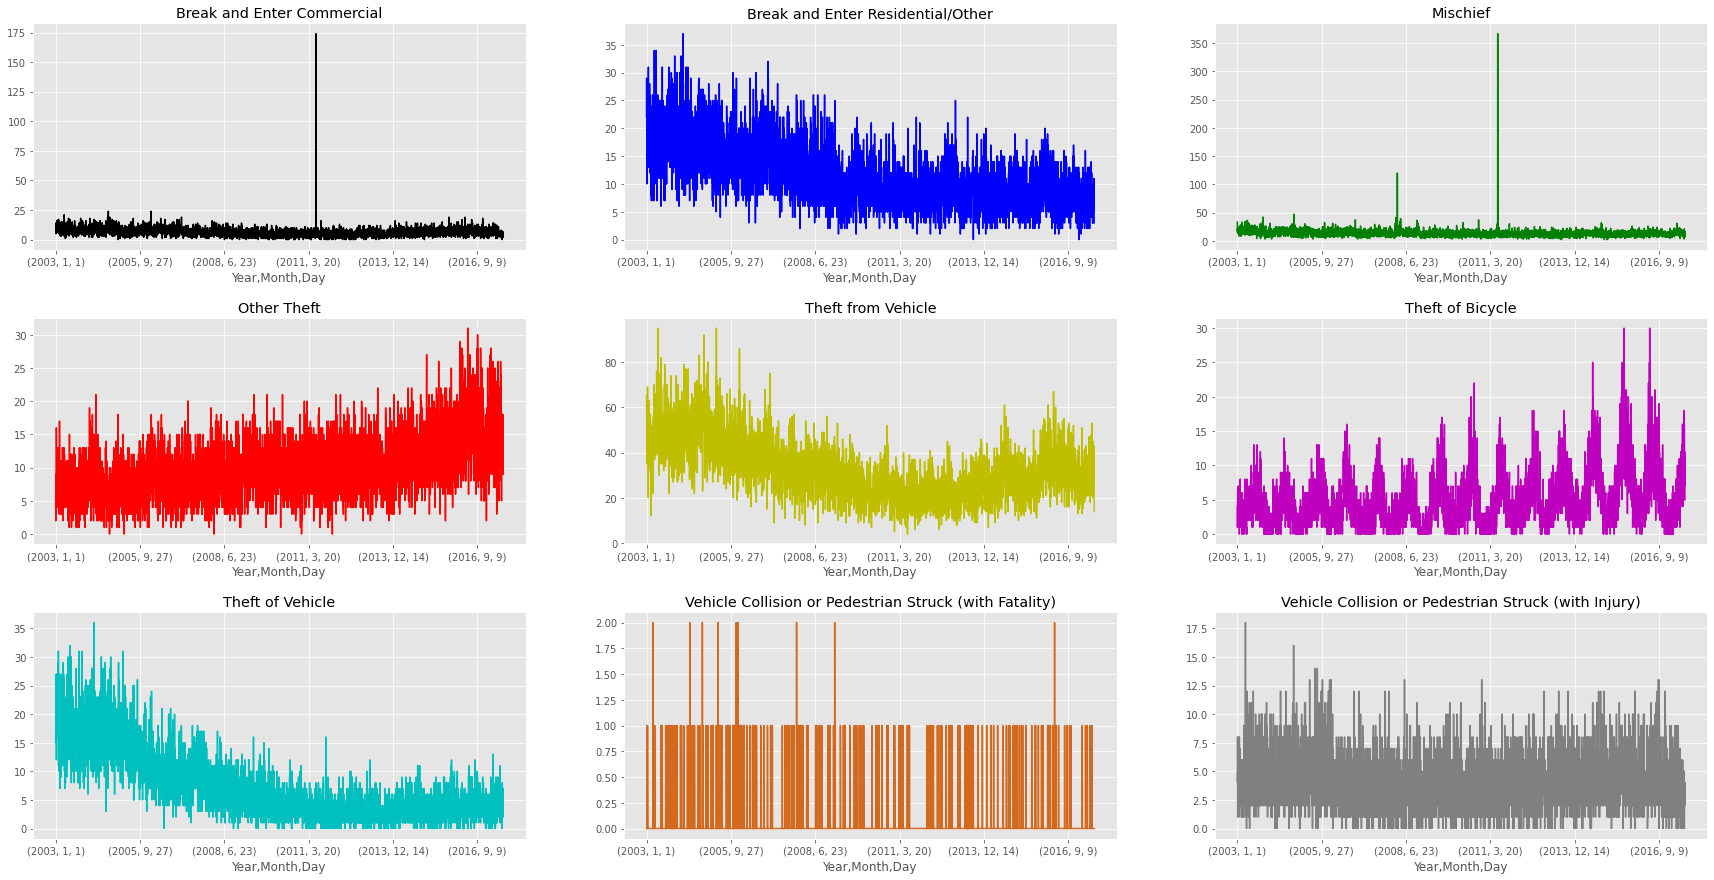

In [ ]:
# Plot Crime Types
plt.style.use('ggplot')
fig = plt.gcf()
clr = ['k','b', 'g', 'r', 'y', 'm', 'c', 'chocolate', 'gray']
fig.set_size_inches(30, 15)

for i in range(0, crime_types.shape[1]):
  ax = plt.subplot(3, 3, i + 1)
  plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
  ax.title.set_text(crime_types.columns[i]) 
  crime_types.iloc[:,i].plot(c = clr[i])

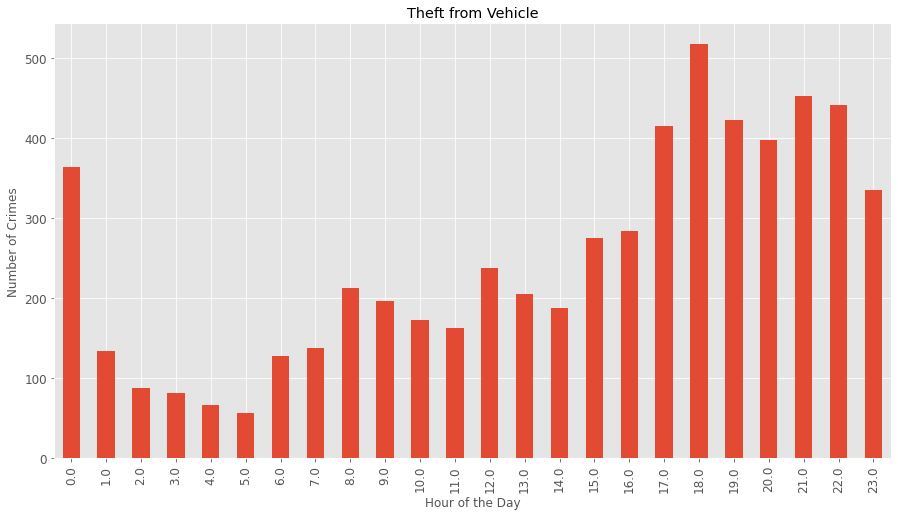

In [ ]:
# Plot Crime/Hour Plot 
year  = 2017
crime = 'Theft from Vehicle'

plt.style.use('ggplot')
data = dataset [ (dataset['TYPE'] == crime) & (dataset['YEAR'] == year) ]
ax   = data[['TYPE','HOUR']].groupby(['HOUR'], as_index = False).count().plot(kind = 'bar', x = 'HOUR', title = crime, figsize = (15, 8), fontsize = 12, legend = False, )
ax.set_xlabel('Hour of the Day',  fontsize = 12)
ax.set_ylabel('Number of Crimes', fontsize = 12)
plt.show()

In [ ]:
# Create Map (Center Vancouver)
map_1 = folium.Map(location = [49.24, -123.11], zoom_start = 12)

# Hot Spot Parameters
year  = 2017
crime = 'Theft from Vehicle'

# Hot Spot Data
data     = dataset[ (dataset['YEAR'] == year) & (dataset['TYPE'] == crime)].reset_index()
data     = data[['Latitude', 'Longitude', 'HOUR']]
gps      = []
hour_tm  = []
hour_lst = []

# Hot Spot Data List
data.sort_values(by = ['HOUR'], ascending = True, inplace = True)
hour_tm.append( str(data.iloc[0, 2]))
hour_lst.append( [ data.iloc[0, 0], data.iloc[0, 1] ] )
for i in range(1, data.shape[0]):
  if (data.iloc[i, 2] == data.iloc[i-1, 2]):
    hour_lst.append( [ data.iloc[i, 0], data.iloc[i, 1] ] )
  else:
    gps.append( hour_lst )
    hour_tm.append( str(data.iloc[i, 2]))
    hour_lst = []
gps.append( hour_lst )

# Hot Spot Map
HeatMapWithTime(gps, index = hour_tm, radius = 25, gradient = {0.1: 'blue', 0.2: 'lime', 0.6: 'yellow', 0.8: 'orange', 1: 'red'}, min_opacity = 0.5, max_opacity = 0.5, use_local_extrema = True).add_to(map_1)
map_1

In [ ]:
# Pre-processing
input_length  = 14 # Input Sequence Length
output_length = 7  # Output Sequence Length (output_length >= 2)
slide_window  = 7  # Steps Taken Ahead
dataX         = [] # Input Sequence Data
dataY         = [] # Output Data
 
for i in range(0, crime_types.shape[0] - input_length - output_length + 1, slide_window):
    inp = crime_types.iloc[i:i + input_length, 4]
    out = crime_types.iloc[i + input_length:i + input_length + output_length, 4]
    dataX.append(inp)
    dataY.append(out)

In [ ]:
# Check dataX and dataY
n = 1
print('Input: ', dataX[n], ' Output: ', dataY[n])
print('dataX Size: ', len(dataX), ' dataY Size: ', len(dataY))

Input:  Year  Month  Day
2003  1      8      55.0
             9      36.0
             10     63.0
             11     46.0
             12     53.0
             13     69.0
             14     38.0
             15     35.0
             16     35.0
             17     52.0
             18     49.0
             19     58.0
             20     40.0
             21     29.0
Name: Theft from Vehicle, dtype: float64  Output:  Year  Month  Day
2003  1      22     20.0
             23     38.0
             24     48.0
             25     36.0
             26     53.0
             27     43.0
             28     35.0
Name: Theft from Vehicle, dtype: float64
dataX Size:  756  dataY Size:  756


In [ ]:
# Train, Validation & Test Sets
train_size = int(len(dataX) * 0.70)
valid_size = train_size + int(len(dataX) * 0.20)

# X [samples, input sequence length, number_of_dimensions]
X       = np.reshape(dataX, (len(dataX), 1, len(dataX[0])))
train_X = X[:train_size, :, :]
valid_X = X[train_size:valid_size, :, :]
test_X  = X[valid_size:, :, :]

# Check Train, Validation & Test X
print('Train X First Sample: \n', train_X[0])
print('Train X Shape: ', train_X.shape)
print('Validation X First Sample: \n', valid_X[0])
print('Validation X Shape: ', valid_X.shape)
print('Test X First Sample: \n', test_X[0])
print('Test X Shape: ', test_X.shape)


Train X First Sample: 
 [[65. 55. 54. 52. 35. 49. 53. 55. 36. 63. 46. 53. 69. 38.]]
Train X Shape:  (529, 1, 14)
Validation X First Sample: 
 [[11. 12. 14. 18. 27. 16. 16. 13. 20. 23. 13. 10. 16. 19.]]
Validation X Shape:  (151, 1, 14)
Test X First Sample: 
 [[61. 47. 61. 61. 56. 38. 42. 33. 26. 24. 35. 33. 46. 27.]]
Test X Shape:  (76, 1, 14)


In [ ]:
# Train, Validation & Test Sets
train_size = int(len(dataY) * 0.70)
valid_size = train_size + int(len(dataY) * 0.20)

# Y [samples, input sequence length]
Y       = np.reshape(dataY, (len(dataY), len(dataY[0])))
train_y = Y[:train_size, :]
valid_y = Y[train_size:valid_size, :]
test_y  = Y[valid_size:, :]

# Check Train, Validation & Test Y
print('Train Y First Sample: \n', train_y[0])
print('Train Y Shape: ', train_y.shape)
print('Validation Y First Sample: \n', valid_y[0])
print('Validation Y Shape: ', valid_y.shape)
print('Test Y First Sample: \n', test_y[0])
print('Test Y Shape: ', test_y.shape)

Train Y First Sample: 
 [35. 35. 52. 49. 58. 40. 29.]
Train Y Shape:  (529, 7)
Validation Y First Sample: 
 [12. 32. 22. 13. 19. 29. 22.]
Validation Y Shape:  (151, 7)
Test Y First Sample: 
 [40. 37. 49. 48. 40. 38. 45.]
Test Y Shape:  (76, 7)


In [ ]:
# Vanilla LSTM Model
inp = Input( shape = (1, len(dataX[0])) ) 
x   = LSTM(64, activation = 'relu', return_sequences = True,  return_state = False)(inp)
x   = LSTM(64, activation = 'relu', return_sequences = False, return_state = False)(x)
out = Dense(train_y.shape[-1], activation = 'linear')(x)

lstm = Model(inp, out) 
lstm.compile(optimizer = 'adam', loss = 'mse')
lstm.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 14)]           0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 64)             20224     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 7)                 455       
                                                                 
Total params: 53,703
Trainable params: 53,703
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Checkpoint
filepath       = 'lstm.hdf5'
checkpoint     = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]

In [ ]:
# Fit
lstm_history = lstm.fit( train_X, train_y, batch_size = 16, epochs = 100, callbacks = callbacks_list, validation_data = (valid_X, valid_y), shuffle = False)
lstm.load_weights('lstm.hdf5')

Epoch 1/100
28/34 [=======================>......] - ETA: 0s - loss: 1335.7061
Epoch 00001: loss improved from inf to 1158.89636, saving model to lstm.hdf5
34/34 [==============================] - 3s 16ms/step - loss: 1158.8964 - val_loss: 198.1349
Epoch 2/100
25/34 [=====================>........] - ETA: 0s - loss: 187.1107
Epoch 00002: loss improved from 1158.89636 to 153.39676, saving model to lstm.hdf5
34/34 [==============================] - 0s 6ms/step - loss: 153.3968 - val_loss: 62.6365
Epoch 3/100
25/34 [=====================>........] - ETA: 0s - loss: 95.7128 
Epoch 00003: loss improved from 153.39676 to 83.86339, saving model to lstm.hdf5
34/34 [==============================] - 0s 6ms/step - loss: 83.8634 - val_loss: 59.3754
Epoch 4/100
26/34 [=====================>........] - ETA: 0s - loss: 87.6345 
Epoch 00004: loss improved from 83.86339 to 78.28072, saving model to lstm.hdf5
34/34 [==============================] - 0s 6ms/step - loss: 78.2807 - val_loss: 59.5533
Epoch

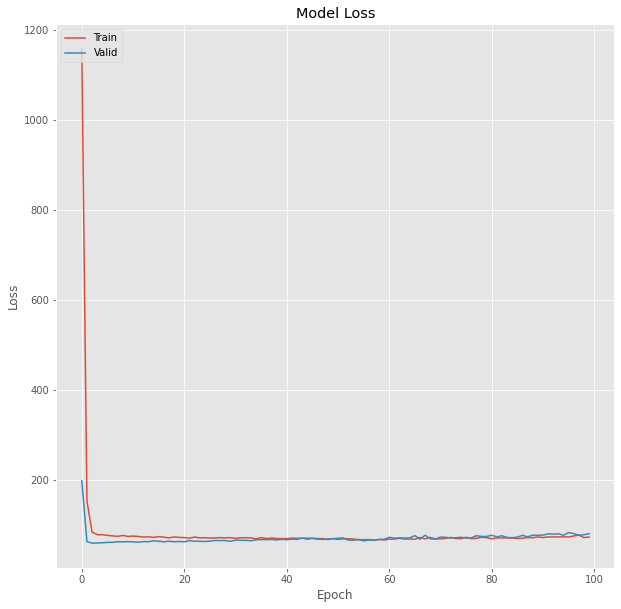

In [ ]:
# Plot loss
plt.style.use('ggplot')
plt.figure(figsize = [10, 10])
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc = 'upper left')
plt.show()

MSE:  196.05248910410785


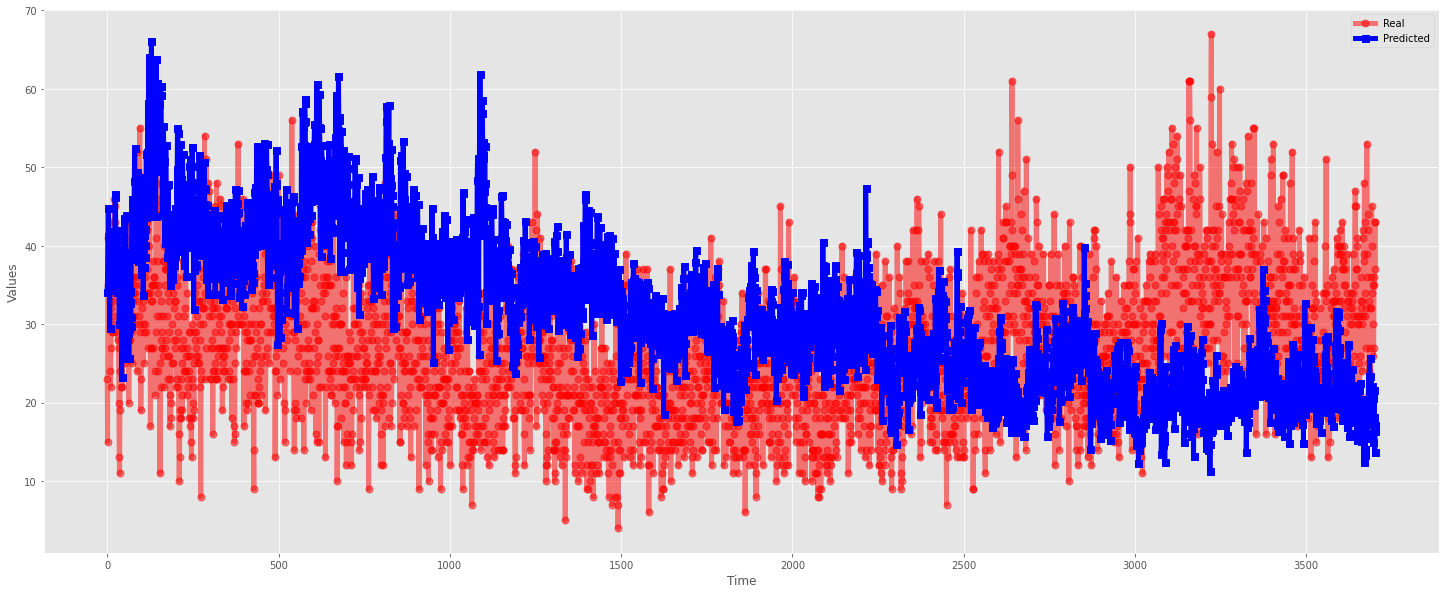

In [ ]:
# Prediction - Train
prediction = lstm.predict(train_X)
real = [item for sublist in dataY[-len(prediction):] for item in sublist]
pred = prediction.flatten().tolist()

# MSE
mse = ((( np.array(real) - np.array(pred)) ** 2).mean())
print('MSE: ', mse)

# Plot Prediction
plt.style.use('ggplot')
plt.figure(figsize = [25, 10])
plt.plot(real, color = 'red',  marker = 'o', markersize = 7, lw = 5, alpha = 0.5, label = 'Real')
plt.plot(pred, color = 'blue', marker = 's', markersize = 7, lw = 5, alpha = 1.0, label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show() 

MSE:  122.81029235243369


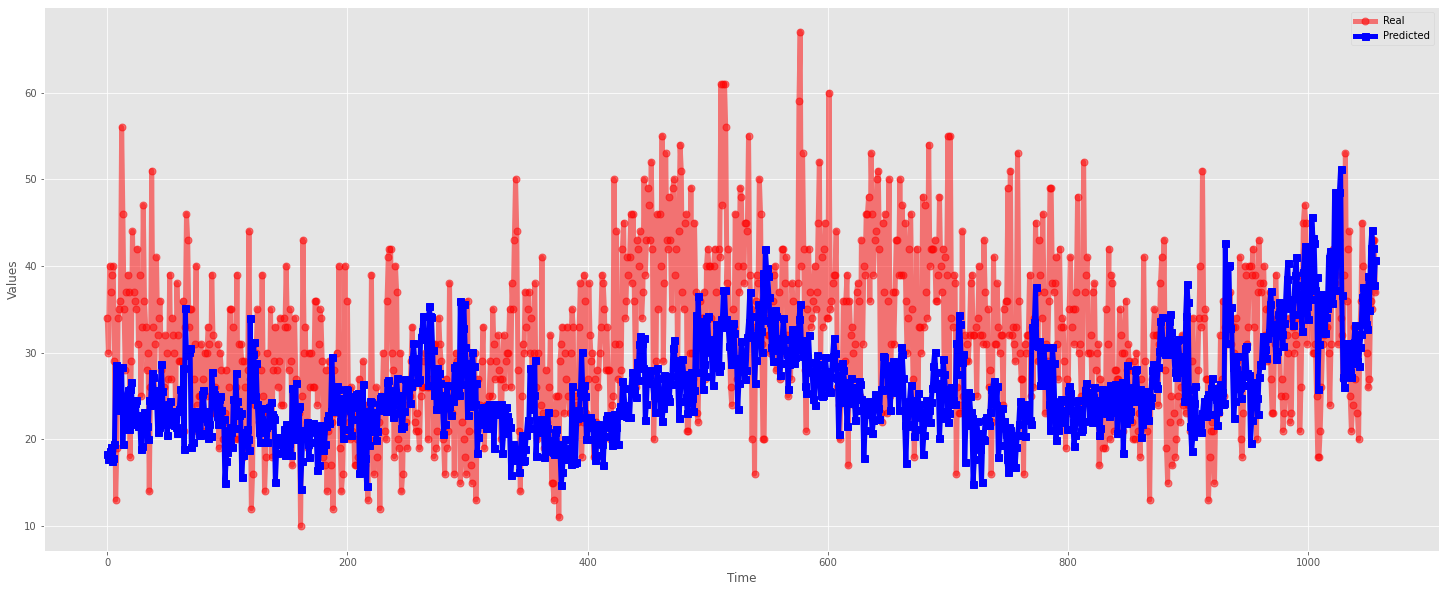

In [ ]:
# Prediction - Validation
prediction = lstm.predict(valid_X)
real = [item for sublist in dataY[-len(prediction):] for item in sublist]
pred = prediction.flatten().tolist()

# MSE
mse = ((( np.array(real) - np.array(pred)) ** 2).mean())
print('MSE: ', mse)

# Plot Prediction
plt.style.use('ggplot')
plt.figure(figsize = [25, 10])
plt.plot(real, color = 'red',  marker = 'o', markersize = 7, lw = 5, alpha = 0.5, label = 'Real')
plt.plot(pred, color = 'blue', marker = 's', markersize = 7, lw = 5, alpha = 1.0, label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show() 

MSE:  78.83556657952967


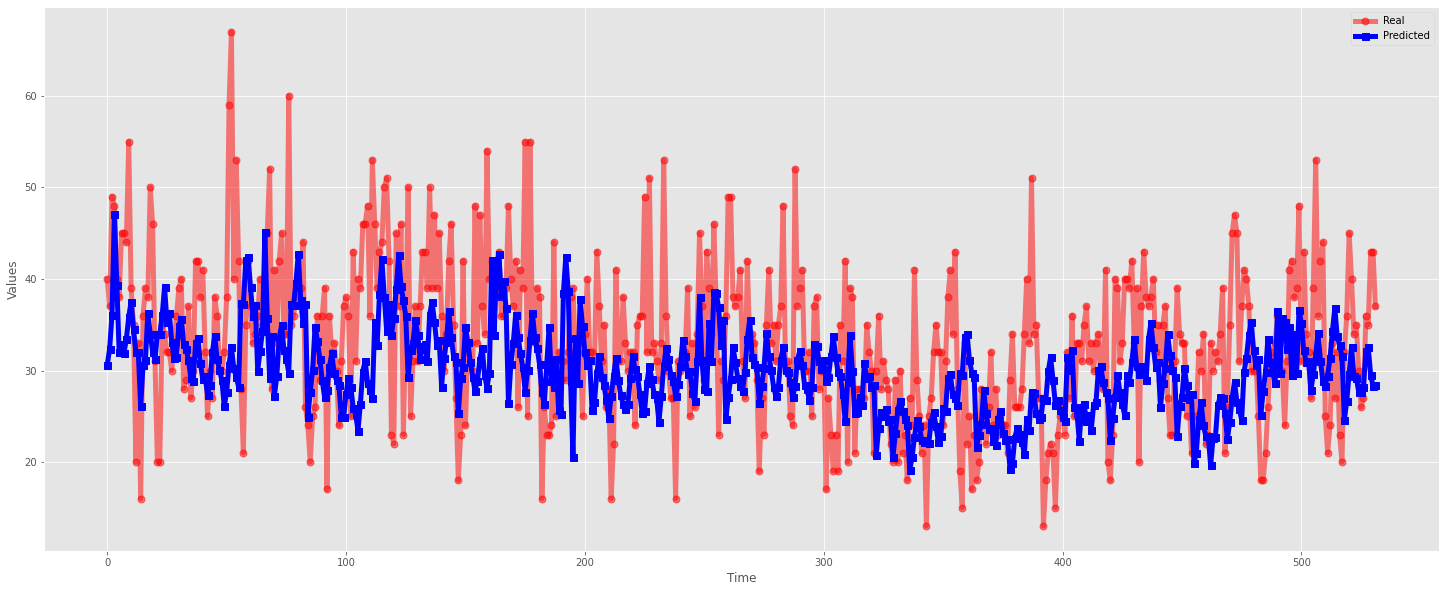

In [ ]:
# Prediction
prediction = lstm.predict(test_X)
real = [item for sublist in dataY[-len(prediction):] for item in sublist]
pred = prediction.flatten().tolist()

# MSE
mse = ((( np.array(real) - np.array(pred)) ** 2).mean())
print('MSE: ', mse)

# Plot Prediction
plt.style.use('ggplot')
plt.figure(figsize = [25, 10])
plt.plot(real, color = 'red',  marker = 'o', markersize = 7, lw = 5, alpha = 0.5, label = 'Real')
plt.plot(pred, color = 'blue', marker = 's', markersize = 7, lw = 5, alpha = 1.0, label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show() 

In [ ]:
# tmp Directory
print(os.listdir())

['.config', 'AI-04-RNN-Crimes.zip.2', 'lstm.hdf5', 'AI-04-RNN-Crimes.zip.4', 'AI-04-RNN-Crimes.zip.3', 'AI-04-RNN-Crimes.zip.1', 'AI-04-RNN-Crimes.zip', 'AI-04-RNN-Crimes.txt', 'sample_data']


In [ ]:
# COLAB - Download Weigths
files.download('lstm.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>